<a href="https://colab.research.google.com/github/rafisondi/ml-playground/blob/main/Gaussian_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.spatial

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)


#Simulation of 5 random Walks

The random distance is sampled from a normal distribution with mean 0 and variance sqrt(dt)


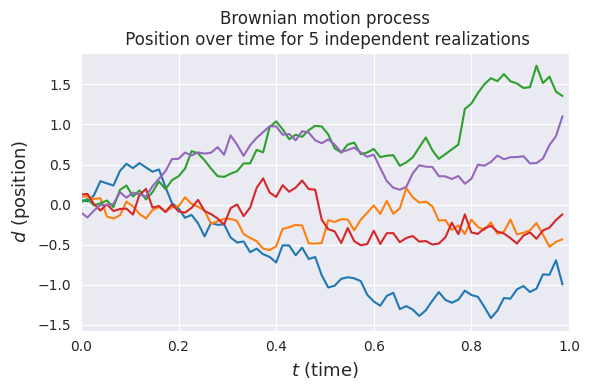

In [2]:
nb_processes = 5
total_time = 1
nb_steps = 75
delta_t = total_time / nb_steps
stdev = np.sqrt(delta_t)
walks_list = []

currentWalk = np.zeros(nb_steps)

for i in range(nb_processes):
  current_position = 0
  for t in range(nb_steps):
    current_position += np.random.normal(0,stdev)
    currentWalk[t] = current_position
  walks_list.append(currentWalk.copy())

plt.figure(figsize=(6, 4))
# Make the plots
t = np.arange(0, total_time, delta_t)
for i in range(nb_processes):
    plt.plot(t, walks_list[i])
plt.title((
    'Brownian motion process\n '
    'Position over time for 5 independent realizations'))
plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.xlim([-0, 1])
plt.tight_layout()
plt.show()

In [3]:
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

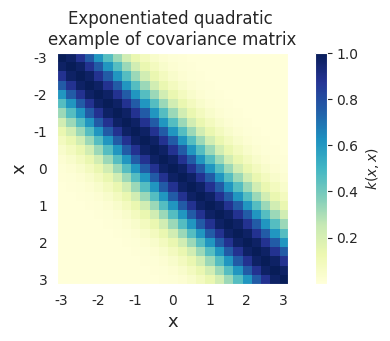

In [4]:
# Show covariance matrix example from exponentiated quadratic
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 3))
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, 25), 1)
Σ = exponentiated_quadratic(X, X)
# Plot covariance matrix
im = ax1.imshow(Σ, cmap=cm.YlGnBu)
cbar = plt.colorbar(
    im, ax=ax1, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
ax1.set_title((
    'Exponentiated quadratic \n'
    'example of covariance matrix'))
ax1.set_xlabel('x', fontsize=13)
ax1.set_ylabel('x', fontsize=13)
ticks = list(range(xlim[0], xlim[1]+1))
ax1.set_xticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_yticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_xticklabels(ticks)
ax1.set_yticklabels(ticks)
ax1.grid(False)

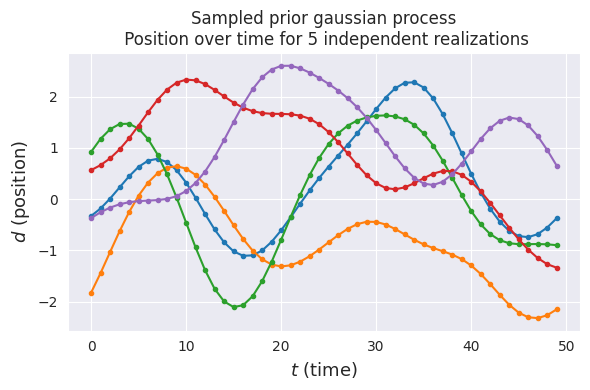

In [5]:
# Sample function realizations from Gaussian Process
samples_from_gp = 50
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, samples_from_gp), 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(samples_from_gp), cov=Σ,
    size=number_of_functions)

plt.figure(figsize=(6, 4))
t = np.arange(0, samples_from_gp)
for i in range(number_of_functions):
    plt.plot(t, ys[i, :], linestyle='-', marker='o', markersize=3)
plt.title((
    'Sampled prior gaussian process\n '
    'Position over time for 5 independent realizations'))
plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.tight_layout()
plt.show()


# Sampling the posterior without any noise on the samples y


In [6]:
def GaussianProcess(mu_prior, X, X_new ,y, var_noise = 0.0):
  sigma11 = exponentiated_quadratic(X, X) + var_noise * np.eye(len(X))
  sigma12 = exponentiated_quadratic(X, X_new)
  sigma22 = exponentiated_quadratic(X_new, X_new)
  mu_post = sigma12.T @ np.linalg.inv(sigma11) @ (y - mu_prior)
  sigma_post = sigma22 - sigma12.T @ np.linalg.inv(sigma11) @ sigma12
  return mu_post, sigma_post

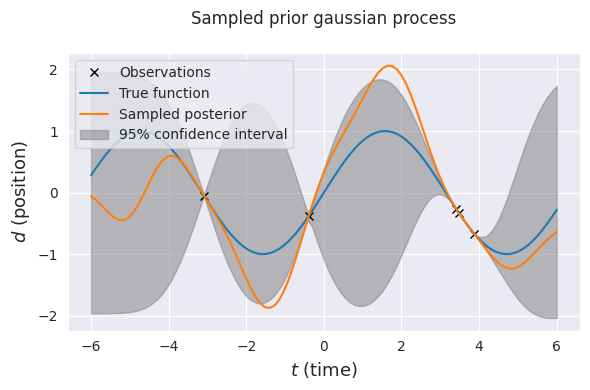

In [7]:
# Posterior calculation based on sampled realization of a function f
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 5 # number of observation of function f
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)

n_inference = 100
X2 = np.linspace(*domain, n_inference).reshape(-1, 1)

# Gaussian Process posterior
mu_post, sigma_post = GaussianProcess(np.zeros(n1), X1, X2, y1)
ys = np.random.multivariate_normal(
    mean=mu_post, cov=sigma_post)

# Covariance of each point
diag = np.diag(sigma_post)
std_dev = np.sqrt(diag)
confidence_interval = 1.96 * std_dev

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(X1, y1, 'kx', label='Observations')
plt.plot(np.linspace(*domain, 100), f_sin(np.linspace(*domain, 100)),
         label='True function')
plt.plot(X2, ys, label='Sampled posterior')
plt.title((
    'Sampled prior gaussian process\n '))
plt.fill_between(X2.flatten(),
                 (mu_post - confidence_interval),
                 (mu_post + confidence_interval),
                 color='gray', alpha=0.5, label='95% confidence interval')

plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Sampling from function with noise on samples y = f + epsilon

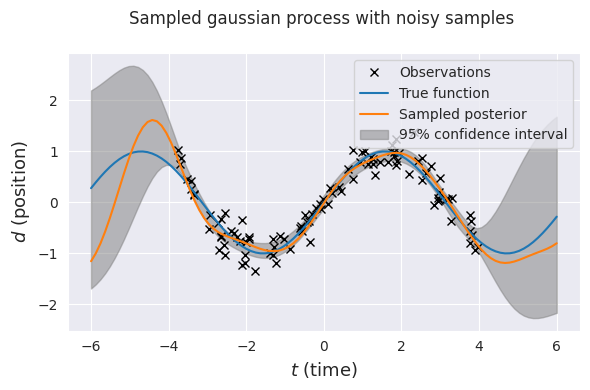

In [9]:
# Posterior calculation based on sampled realization of a function f
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 100 # number of observation of function f
var_noise = 0.05
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1) + np.random.normal(0, np.sqrt(var_noise), size=(n1, 1)).flatten()

n_inference = 100
X2 = np.linspace(*domain, n_inference).reshape(-1, 1)

# Gaussian Process posterior
mu_post, sigma_post = GaussianProcess(np.zeros(n1), X1, X2, y1, var_noise)
ys = np.random.multivariate_normal(
    mean=mu_post, cov=sigma_post)

# Covariance of each point
diag = np.diag(sigma_post)
std_dev = np.sqrt(diag)
confidence_interval = 1.96 * std_dev

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(X1, y1, 'kx', label='Observations')
plt.plot(np.linspace(*domain, 100), f_sin(np.linspace(*domain, 100)),
         label='True function')
plt.plot(X2, ys, label='Sampled posterior')
plt.title((
    'Sampled gaussian process with noisy samples \n '))
plt.fill_between(X2.flatten(),
                 (mu_post - confidence_interval),
                 (mu_post + confidence_interval),
                 color='gray', alpha=0.5, label='95% confidence interval')

plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.legend(loc='best')
plt.tight_layout()
plt.show()